# Image classification using Residual Network

In [1]:
import torch 
import torchvision 
from torchvision.datasets import ImageFolder
import torchvision.transforms as tfm
from tqdm import tqdm
import matplotlib.pyplot as plt 
from torch.utils.data import DataLoader 
import numpy as np 

%matplotlib inline 

In [2]:
# this is the mean and std for ImageNet dataset
Mean = np.asarray([ 0.485, 0.456, 0.406 ])
Std = np.asarray([ 0.229, 0.224, 0.225 ])

In [3]:
train_tfms = tfm.Compose([tfm.RandomCrop(224, padding=4, padding_mode='reflect'), 
                         tfm.RandomHorizontalFlip(0.5),                          
                         tfm.RandomVerticalFlip(0.6),
                         tfm.ToTensor(), 
                         tfm.Normalize(mean=Mean, std=Std, inplace=True), # normalize image based on mean and std of ImageNet dataset
                         tfm.Lambda(lambda x: x.mul(255.))
                         ])
test_tfms = tfm.Compose([
    tfm.ToTensor(),
    tfm.Normalize(mean=Mean, std=Std, inplace=True), # normalize image based on mean and std of ImageNet dataset
    tfm.Lambda(lambda x: x.mul(255.))
])

In [4]:
from PIL import Image

load_tfms = tfm.Compose([
    tfm.Resize((224,224)), 
    tfm.ToTensor(),
    tfm.Normalize(Mean, Std, inplace=True), # normalize image based on mean and std of ImageNet dataset
    tfm.Lambda(lambda x: x.mul(255.))
    ])

def loadPicture(path):    
    image = Image.open(path).convert('RGB')    
    img=load_tfms(image)    
    plt.imshow(image)
    return img 

In [5]:
def showTensorImage(image):
    tfm=transforms.Compose([
        # reverse the normalization
        transforms.Lambda(lambda x: x.div(255.) ), 
        transforms.Normalize((-1 * Mean / Std), (1.0 / Std),inplace=True) 
        ])
    img=tfm(image)
    plt.figure(figsize=(10,10) )
    plt.imshow(img.permute(1,2,0))

In [6]:
root='balls'

trainDS=ImageFolder(f'{root}/train', transform=train_tfms)
valDS=ImageFolder(f'{root}/valid', transform=train_tfms)
testDS=ImageFolder(f'{root}/test', transform=test_tfms)
print(f'train ds has {len(trainDS)},  val ds has {len(valDS) } and testDS has {len(testDS)} items with {len(trainDS.classes)} classes')
img, _=trainDS[1]
print(img.shape)

train ds has 2860,  val ds has 120 and testDS has 120 items with 24 classes
torch.Size([3, 224, 224])


### Let's look at some samples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


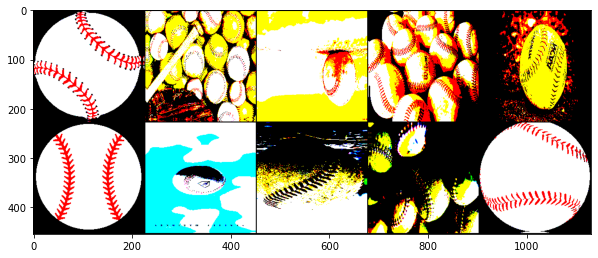

In [7]:
from torchvision.utils import make_grid
num_images=10
images = [trainDS[idx][0] for idx in range(num_images)]
plt.figure(figsize=(10,10) )

image_grid = make_grid(images, nrow=num_images//2)            
plt.imshow(image_grid.permute(1, 2, 0).squeeze(0))    


In [8]:
def getDataLoaders(batchSize):
    trainldr=DataLoader(trainDS, shuffle=True, num_workers=4, pin_memory=True, batch_size=batchSize ) 
    valldr=DataLoader(valDS, num_workers=4, pin_memory=True, batch_size=batchSize)
    testldr=DataLoader(testDS,num_workers=4, pin_memory=True, batch_size=batchSize)

    return trainldr, valldr, testldr 

## Get the Resnet model

In [9]:
from ResNet import ResNet
from torchvision import models

def getModel(ntwkType, ownModel=True, numClasses=len(trainDS.classes)):
    model=None

    if ownModel:
        model= ResNet(img, numClasses, ntwkType)
    else:
        if ntwkType==0:
            model=models.resnet18(pretrained=False, num_classes=numClasses)
        elif ntwkType==1:        
            model=models.resnet34(pretrained=False, num_classes=numClasses)
        elif ntwkType==2:
            model=models.resnet50(pretrained=False, num_classes=numClasses)
        elif ntwkType==3:
            model=models.resnet101(pretrained=False, num_classes=numClasses)
        elif ntwkType==4:
            model=models.resnet152(pretrained=False, num_classes=numClasses)
    return model 

In [10]:
model=getModel(0, False)
output=model(img.unsqueeze(0))
print(f'output has shape {output.shape} ')

output has shape torch.Size([1, 24]) 


In [11]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

cuda


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
def getAccuracy(outputs, labels):
    preds=torch.argmax(outputs, dim=1)
    return torch.sum(preds==labels).item()

In [13]:
import torch.nn.functional as F  

def train (ldr, opt, trainModel, sched=None):    
    num_items=0
    losses=0.
    accs=0.
    trainModel.train()
    for batch in tqdm(ldr):        
        opt.zero_grad()        
        imgs, lbls=batch 
        num_items+=len(lbls)
        imgs=imgs.to(device)
        lbls=lbls.to(device)
        outputs=trainModel(imgs)
        loss=F.cross_entropy(outputs, lbls)
        losses+=(loss.item()*len(lbls))
        accs+=getAccuracy(outputs, lbls)
        loss.backward()        
        opt.step()
        if sched is not None:
            sched.step()
    return losses/num_items, accs/num_items 


In [14]:
def evaluate(ldr, evalModel):
    size=0
    losses=0. 
    accs=0. 
    evalModel.eval()
    for batch in tqdm(ldr):
        imgs, lbls=batch 
        size+=len(lbls)
        imgs=imgs.to(device )
        lbls=lbls.to(device )
        outputs=evalModel(imgs)
        loss=F.cross_entropy(outputs, lbls)
        losses+=(loss.item()*len(lbls))
        accs+=getAccuracy(outputs, lbls)
    return losses/size , accs/size 

In [15]:
import torch.optim as optim 

batchsize=256
lr=5e-4
epochs=50

opt=optim.Adam(model.parameters(), lr=lr)
trainLdr, valLdr, testLdr =getDataLoaders(batchsize)
sched = torch.optim.lr_scheduler.OneCycleLR(opt,max_lr=lr*2.5, epochs=epochs,steps_per_epoch=len(trainLdr))

In [16]:
import  IPython.display as display 

def showResults(tloss, tacc, vloss, vacc):
    display.clear_output(wait=True )
    print('epoch\t TLosses\t TAccs\t\t VLosses\t VAccs')
    print('------------------------------------------------------------')
    for i in range(len(tloss)):
        print(f'{i+1}\t {tloss[i]:.3f}\t\t {tacc[i]*100.:.3f}% \t {vloss[i]:.3f}\t\t {vacc[i]*100.:.3f}%')

In [17]:
trainLosses=[]
trainAccs=[]
valLosses=[]
valAccs=[]
curValAcc=0. 
savedep=-1

for ep in range(epochs):
    print(f'\nTraining {ep+1}/{epochs}')
    losses, accs=train(trainLdr, opt, model, sched)
    trainLosses+=[losses]
    trainAccs+=[accs]
    print(f'Validating {ep+1}/{epochs}')
    losses, accs=evaluate(valLdr, model)
    valLosses+=[losses]
    valAccs+=[accs]
    if accs>curValAcc:
        savedep=ep 
        curValAcc=accs 
        torch.save(model, "saved.pth" )
    showResults(trainLosses, trainAccs, valLosses, valAccs)

epoch	 TLosses	 TAccs		 VLosses	 VAccs
------------------------------------------------------------
1	 2.941		 13.497% 	 4.235		 7.500%
2	 2.283		 37.413% 	 2.350		 33.333%
3	 1.894		 46.923% 	 1.983		 44.167%
4	 1.580		 55.769% 	 1.681		 47.500%
5	 1.389		 60.035% 	 2.105		 42.500%
6	 1.273		 61.853% 	 1.703		 56.667%
7	 1.184		 65.175% 	 2.459		 42.500%
8	 1.154		 66.119% 	 2.140		 50.833%
9	 1.186		 62.692% 	 2.125		 38.333%
10	 1.140		 65.629% 	 3.540		 32.500%
11	 1.075		 68.322% 	 1.661		 49.167%
12	 1.051		 68.881% 	 1.998		 50.000%
13	 0.938		 71.049% 	 1.769		 44.167%
14	 0.981		 70.594% 	 1.318		 58.333%
15	 0.905		 72.448% 	 1.550		 58.333%
16	 0.902		 72.098% 	 1.040		 72.500%
17	 0.767		 76.189% 	 1.595		 50.000%
18	 0.752		 76.713% 	 1.239		 63.333%
19	 0.698		 78.636% 	 1.191		 69.167%
20	 0.700		 78.007% 	 1.198		 69.167%
21	 0.621		 80.315% 	 0.837		 75.833%
22	 0.563		 82.168% 	 2.067		 52.500%
23	 0.564		 81.608% 	 1.075		 64.167%
24	 0.560		 82.343% 	 0.944		 74.167

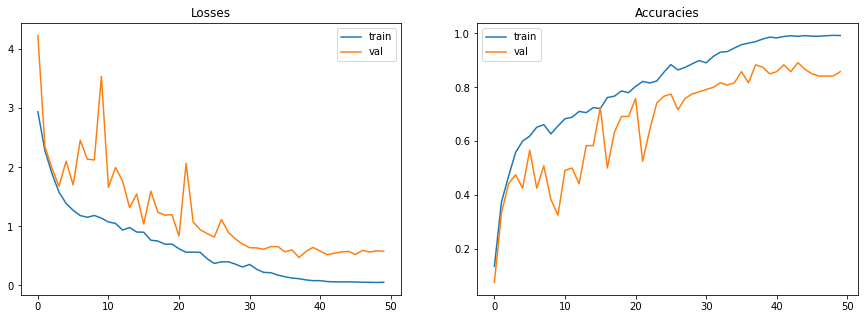

In [18]:
fig=plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.title('Losses')
plt.plot(trainLosses, label='train')
plt.plot(valLosses, label='val')
plt.legend()
plt.subplot(1, 2, 2)
plt.title('Accuracies')
plt.plot(trainAccs, label='train')
plt.plot(valAccs, label='val')
plt.legend()

plt.show()

## Loading best oerfirnubg weights

In [19]:
print(f'best performing val accuracy={valAccs[savedep]*100.0:.3f}% ')
model2=torch.load('saved.pth')
model2.to(device)

best performing val accuracy=89.167% 


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
losses, accs=evaluate(testLdr, model2)
print(f'Test Losses={losses:.3f}, accuracies={accs*100. : .2f} % ')

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.03it/s]

Test Losses=0.606, accuracies= 82.50 % 


## Inferencing with images containing various fruits

iimg shape: torch.Size([3, 224, 224]) 


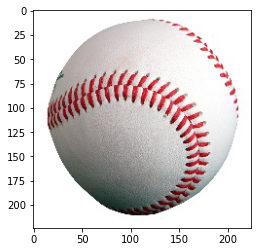

In [21]:

img='1.jpg'
path=f'{root}/{img}'
img=loadPicture(path)
print(f'iimg shape: {img.shape} ')

In [22]:
def detectObject(img, trainedModel):
    img=img.to(device)
    output=trainedModel(img.unsqueeze(0) )
    output=F.softmax(output, dim=1)
    prob, id=torch.max(output, dim=1)    
    return prob.to('cpu') , id.to('cpu')

In [23]:
print(img.shape)
prob, id=detectObject(img, model2)
prob=prob.detach().numpy()
print(f'detected {trainDS.classes[id] } to {prob[0]*100. :.2f}%  ')

torch.Size([3, 224, 224])
detected baseball to 98.61%  
